<a href="https://colab.research.google.com/github/carbotton/tdl_tarea_1/blob/eda_preproc_data-aug/Tarea_1_letra.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tarea 1 - Taller de Deep Learning

**Fecha de entrega: 19/10/2025**  
**Puntaje máximo: 15**

## Introducción

El objetivo de esta tarea es evaluar su conocimiento sobre Deep Learning aplicado a un caso de uso real. En particular, vamos a evaluar la performance de sus modelos en una tarea de clasificación de escenas.

**Dataset**

El dataset a ser utilizado es **Imagenette**, una versión simplificada de ImageNet que consiste de 10 clases. Pueden encontrar más información y descargarlo en el siguiente [link](https://pytorch.org/vision/main/generated/torchvision.datasets.Imagenette.html).

**Tarea**

Tienen total libertad sobre cómo implementar y resolver el problema así como las técnicas y herramientas que quieran usar. Recomendamos usar Colab por simplicidad, pero pueden implementarlo en sus máquinas si así lo prefieren. La única limitante es que esperamos que la entrega sea en formato .ipynb (Jupyter Notebook) **con las celdas ya ejecutadas**.

**Restricciones**

- No se permite utilizar models pre-entrenados (cada modelo debe ser implementado desde cero)
- Se requiere que utilicen al menos 2 técnicas de **regularización** (Dropout, BatchNorm, Data Augmentation, etc.)
- Se requiere realizar un **análisis de los datos**, que incluya el balanceo de clases y tomar decisiones en base al análisis realizado.
- Las decisiones tomadas sobre el preprocesamiento de las imágenes (transforms, augmentation, etc.) deben ser resultado de la exploración del dataset y estar propiamente justificadas (una sección de exploración en el notebook con comentarios es suficiente).

**Reporte**

En particular, les pedimos que reporten: accuracy, precision, recall y f1.
También se espera poder observar la evolución del modelo (en los datos de train y validación) a medida que se entrena (logs, gráficas, etc).

**Evidencia de Experimentos**

Además, deben presentar evidencia de correr experimentos usando [Weights & Biases (wandb)](https://wandb.ai/). Esto incluye:
- Registros detallados de los experimentos.
- Gráficas y logs de entrenamiento.
- Comparaciones entre diferentes configuraciones de modelos.

In [1]:
!pip install torchinfo

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, random_split
from torchvision.transforms import v2 as T
from torchvision.io import read_image, ImageReadMode

from torchinfo import summary

import os
from pathlib import Path

from utils import (
    train,
    evaluate,
    model_classification_report,
    show_tensor_image,
    show_tensor_images,
    plot_taining,
    EarlyStopping,
    print_log,
    plot_training,
)

In [3]:
# Fijamos la semilla para que los resultados sean reproducibles
SEED = 34

torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [4]:
import sys
import os

# Configurar límite de memoria MPS para evitar errores de memoria
os.environ["PYTORCH_MPS_HIGH_WATERMARK_RATIO"] = "0.0"

# definimos el dispositivo que vamos a usar
DEVICE = "cpu"  # por defecto, usamos la CPU
if torch.cuda.is_available():
    DEVICE = "cuda"  # si hay GPU, usamos la GPU
elif torch.backends.mps.is_available():
    DEVICE = "mps"  # si no hay GPU, pero hay MPS, usamos MPS
elif torch.xpu.is_available():
    DEVICE = "xpu"  # si no hay GPU, pero hay XPU, usamos XPU

print(f"Usando {DEVICE}")

NUM_WORKERS = 0 # Win y MacOS pueden tener problemas con múltiples workers
if sys.platform == 'linux':
    NUM_WORKERS = 4  # numero de workers para cargar los datos (depende de cada caso)

print(f"Usando {NUM_WORKERS}")

Usando mps
Usando 0


In [5]:
BATCH_SIZE = 32  # tamaño del batch reducido para evitar problemas de memoria

# Exploracion de datos

## Carga de datos

In [6]:
DATA_DIR = Path("data")

# cargamos train y lo dividimos en train y val
imagenette_full_train = datasets.Imagenette(
    DATA_DIR, split="train", download=True
)

In [7]:
name_classes = imagenette_full_train.classes # no puedo usar imagenette_train_dataset.classes porque es un subset (surge de haber hecho el random split, no tengo mas atributos de clase ahi
NUM_CLASES = len(name_classes)

print(f"Clases: {name_classes}")

Clases: [('tench', 'Tinca tinca'), ('English springer', 'English springer spaniel'), ('cassette player',), ('chain saw', 'chainsaw'), ('church', 'church building'), ('French horn', 'horn'), ('garbage truck', 'dustcart'), ('gas pump', 'gasoline pump', 'petrol pump', 'island dispenser'), ('golf ball',), ('parachute', 'chute')]


## Numero de clases y cantidad de imagenes por clase

Todas tienen cantidades similares de imágenes.

Entre la clase que menos tiene y la que más, hay una diferencia de 135 imagenes.

In [8]:
root_dir = "data/imagenette2/train"
classes = os.listdir(root_dir)

class_counts = {}
for cls in classes:
    n_images = len(os.listdir(os.path.join(root_dir, cls)))
    class_counts[cls] = n_images

# Encontrar la clase con menos y más imágenes
min_class = min(class_counts, key=class_counts.get)
max_class = max(class_counts, key=class_counts.get)

print(f"\nClase con MENOS imágenes: {min_class} ({class_counts[min_class]} imágenes)")
print(f"Clase con MÁS imágenes:  {max_class} ({class_counts[max_class]} imágenes)")
print(f"\nLa clase {max_class} tiene {((class_counts[max_class]-class_counts[min_class])/class_counts[max_class])*100:.1f}% más de imágenes que la clase {min_class}")



Clase con MENOS imágenes: n03000684 (858 imágenes)
Clase con MÁS imágenes:  n02979186 (993 imágenes)

La clase n02979186 tiene 13.6% más de imágenes que la clase n03000684


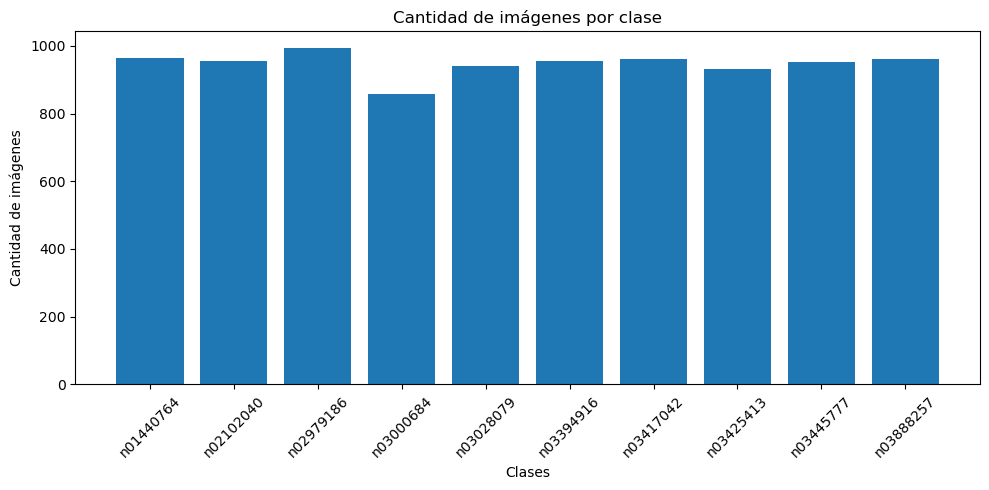

In [9]:
import matplotlib.pyplot as plt

# Ordenar clases para que el gráfico quede prolijo
sorted_classes = sorted(class_counts.keys())
sorted_counts = [class_counts[cls] for cls in sorted_classes]

plt.figure(figsize=(10, 5))
plt.bar(sorted_classes, sorted_counts)
plt.xticks(rotation=45)
plt.xlabel("Clases")
plt.ylabel("Cantidad de imágenes")
plt.title("Cantidad de imágenes por clase")
plt.tight_layout()
plt.show()


## Ver selección random de imágenes

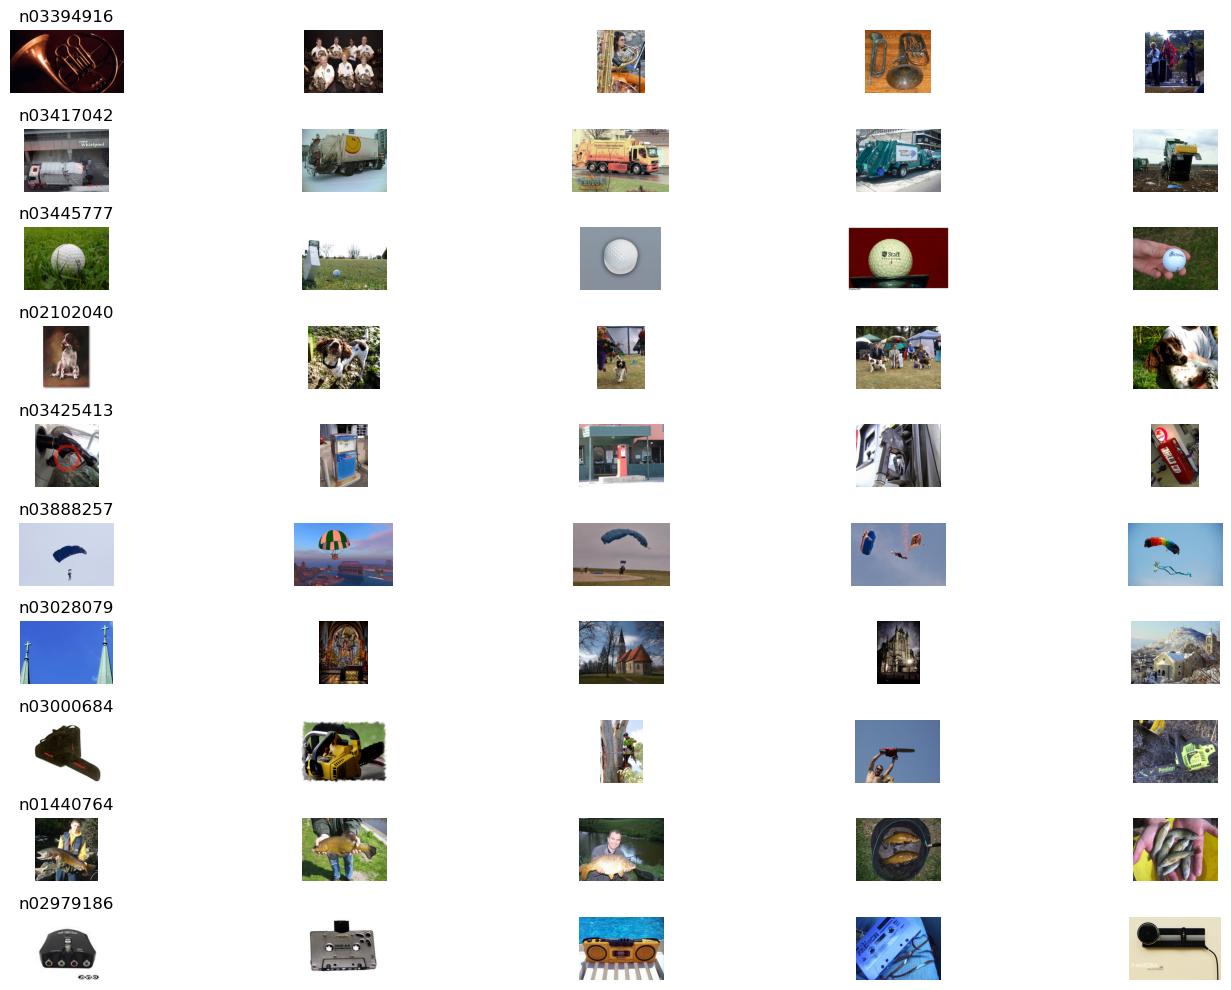

In [10]:
import random
import matplotlib.image as mpimg

n_samples = 5
fig, axs = plt.subplots(len(classes), n_samples, figsize=(15, 10))

for i, cls in enumerate(classes):
    img_files = os.listdir(os.path.join(root_dir, cls))
    for j in range(n_samples):
        img_path = os.path.join(root_dir, cls, random.choice(img_files))
        img = mpimg.imread(img_path)
        axs[i, j].imshow(img)
        axs[i, j].axis("off")
        if j == 0:
            axs[i, j].set_title(cls)
plt.tight_layout()
plt.show()


## Ver tamaños de imágenes

Se puede observar que el tamaño de las imágenes difiere mucho entre una y otra.

In [11]:
from PIL import Image

sizes = []
for cls in classes:
    img_files = os.listdir(os.path.join(root_dir, cls))
    for img_file in img_files[:50]:  # muestra
        img_path = os.path.join(root_dir, cls, img_file)
        with Image.open(img_path) as img:
            sizes.append(img.size)  # (ancho, alto)

size_counts = {}
for size in sizes:
    if size not in size_counts:
        size_counts[size] = 0
    size_counts[size] += 1

# Encontrar el tamaño más y menos común
most_common_size = None
most_common_count = -1
least_common_size = None
least_common_count = float('inf')

for size, count in size_counts.items():
    if count > most_common_count:
        most_common_size = size
        most_common_count = count
    if count < least_common_count:
        least_common_size = size
        least_common_count = count

print(f"\nTotal de tamaños diferentes encontrados: {len(size_counts)}")
print(f"Tamaño MÁS común: {most_common_size} (aparece {most_common_count} veces)")
print(f"Tamaño MENOS común: {least_common_size} (aparece {least_common_count} veces)")



Total de tamaños diferentes encontrados: 215
Tamaño MÁS común: (500, 375) (aparece 124 veces)
Tamaño MENOS común: (1162, 773) (aparece 1 veces)


## Buscar duplicados

In [12]:
import hashlib

def md5(fname):
    with open(fname, "rb") as f:
        return hashlib.md5(f.read()).hexdigest()

hashes = {}
duplicates = []
for cls in classes:
    for img_file in os.listdir(os.path.join(root_dir, cls)):
        path = os.path.join(root_dir, cls, img_file)
        h = md5(path)
        if h in hashes:
            duplicates.append(path)
        else:
            hashes[h] = path
print(f"Encontradas {len(duplicates)} imágenes duplicadas.")


Encontradas 0 imágenes duplicadas.


## Conclusión de la exploracion de datos

Del análisis anterior podemos observar que las clases se encuentran balanceadas, ya que cada una posee un número similar de imágenes. Además, verificamos que no existen duplicados, por lo que no es necesario eliminar ninguna imagen. Finalmente, notamos que las imágenes presentan distintas dimensiones, por lo que es necesario aplicar un proceso de resize para garantizar la consistencia del conjunto de datos.

# LeNet

## Carga de datos con transforms para LeNet

**Transforms:**

Preprocessing -> train y val/test

Data augmentation -> solo train

In [13]:
DATA_DIR = Path("data")

# Wrapper para aplicar transformaciones
class TransformDataset(torch.utils.data.Dataset):
    def __init__(self, subset, transform):
        self.subset = subset
        self.transform = transform
    
    def __len__(self):
        return len(self.subset)
    
    def __getitem__(self, idx):
        image, label = self.subset[idx]
        return self.transform(image), label

def get_dataloaders(
    train_transf, test_transf, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS
):
    """
    Función para obtener los dataloaders de entrenamiento, validación y test

    Args:
    - train_transf: transformaciones para el dataset de entrenaiento
    - test_transf: transformaciones para el dataset de test
    - batch_size: tamaño del batch
    - num_workers: número de workers para cargar los datos
    """

    # descargamos el dataset CIFAR10 (si no lo tenemos ya)
    train_dataset = datasets.Imagenette(
        DATA_DIR, split="train", download=True, transform=None
    ) 
    test_dataset = datasets.Imagenette(
        DATA_DIR, split="val", download=False, transform=test_transf
    )

    # dividimos el dataset de entrenamiento en entrenamiento y validación
    train_size = int(0.8 * len(train_dataset))
    val_size = len(train_dataset) - train_size
    train_dataset, validation_dataset = random_split(
        train_dataset,
        [train_size, val_size],
        generator=torch.Generator().manual_seed(SEED),  # fijamos la semilla
    )

    # aplicamos las transformaciones
    train_dataset = TransformDataset(train_dataset, train_transf)
    validation_dataset = TransformDataset(validation_dataset, test_transf)

    # creamos los dataloaders
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
    )

    valid_loader = DataLoader(
        validation_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
    )

    test_loader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
    )

    return train_loader, valid_loader, test_loader

In [14]:
IMG_SIZE = 128  # Reducir tamaño de imagen para ahorrar memoria

In [15]:
val_tfms_lenet = T.Compose([
    T.ToImage(),
    T.Resize((IMG_SIZE, IMG_SIZE)),
    T.ToDtype(torch.float32, scale=True),
])

In [16]:
train_dataset = datasets.Imagenette(
    DATA_DIR, split="train", download=False, transform=val_tfms_lenet
) 

# Stack todas las imágenes en un tensor
data = torch.stack([img for img, _ in train_dataset])
# Shape: (50000, 3, 32, 32)

# Calcula mean y std por canal
T_MEAN = data.mean(dim=[0, 2, 3])  # Promedia sobre samples, height, width
T_STD = data.std(dim=[0, 2, 3])

print(f"Mean: {T_MEAN}")
print(f"Std: {T_STD}")

Mean: tensor([0.4625, 0.4580, 0.4295])
Std: tensor([0.2768, 0.2730, 0.2967])


In [17]:
train_tfms_lenet = T.Compose([
    T.RandomHorizontalFlip(p=0.5),
    T.RandomRotation(degrees=10),
    # Transformaciones comunes:
    T.ToImage(),
    T.ToDtype(torch.float32, scale=True),
    T.Resize((IMG_SIZE, IMG_SIZE)),
    T.Normalize(mean=T_MEAN, std=T_STD),
])

val_tfms_lenet = T.Compose([
    T.ToImage(),
    T.ToDtype(torch.float32, scale=True),
    T.Resize((IMG_SIZE, IMG_SIZE)),
    T.Normalize(mean=T_MEAN, std=T_STD),
])


## Regularization

Para saber si necesitamos dropout, entrenar una vez y ver si hay overfitting (val_acc=85% agregar ; val_acc=78% no hace falta)

### Data Augmentation
SOLO PARA TRAINING !!!!!!!!!

### Early stopping

Aplicado en training loop

### Dropout

Aplicado en training loop

## Arquitectura del modelo

In [18]:
class LeNet(nn.Module):
    def __init__(self, in_channels, num_classes, use_dropout=False, dropout_p=0.5):
        super(LeNet, self).__init__()
        self.use_dropout = use_dropout
        self.dropout_p = dropout_p

        self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=6, kernel_size=5, stride=1, padding=0)  # 140->136
        self.pool  = nn.AvgPool2d(kernel_size=2, stride=2)                                                   # /2
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1, padding=0)           # 68->64
        self.conv3 = nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5, stride=1, padding=0)         # 32->28
        # self.pool3 = nn.AvgPool2d(kernel_size=28, stride=28)  # 28x28 -> 1x1 (válido para entradas 140x140)
        self.pool3 = nn.AdaptiveAvgPool2d((1, 1))  # reemplaza al AvgPool2d(28,28)


        self.tanh = nn.Tanh()
        # self.linear = nn.Linear(120, 84)
        self.linear = nn.LazyLinear(84)   # en vez de nn.Linear(120, 84)

        self.output = nn.Linear(84, num_classes)
        self.flatten = nn.Flatten(start_dim=1)
        self.dropout = nn.Dropout(p=self.dropout_p) if self.use_dropout else nn.Identity()

    def forward(self, x):
        # x: [B, C=3, 140, 140]
        x = self.tanh(self.conv1(x))   # -> [B, 6, 136, 136]
        x = self.pool(x)               # -> [B, 6, 68, 68]
        x = self.tanh(self.conv2(x))   # -> [B, 16, 64, 64]
        x = self.pool(x)               # -> [B, 16, 32, 32]
        x = self.tanh(self.conv3(x))   # -> [B, 120, 28, 28]
        x = self.pool3(x)              # -> [B, 120, 1, 1]
        x = self.flatten(x)            # -> [B, 120]
        x = self.tanh(self.linear(x))  # -> [B, 84]
        x = self.dropout(x)
        x = self.output(x)             # -> [B, num_classes]
        return x


summary(LeNet(3, NUM_CLASES), input_size=(BATCH_SIZE, 3, IMG_SIZE, IMG_SIZE))

Layer (type:depth-idx)                   Output Shape              Param #
LeNet                                    [32, 10]                  --
├─Conv2d: 1-1                            [32, 6, 124, 124]         456
├─Tanh: 1-2                              [32, 6, 124, 124]         --
├─AvgPool2d: 1-3                         [32, 6, 62, 62]           --
├─Conv2d: 1-4                            [32, 16, 58, 58]          2,416
├─Tanh: 1-5                              [32, 16, 58, 58]          --
├─AvgPool2d: 1-6                         [32, 16, 29, 29]          --
├─Conv2d: 1-7                            [32, 120, 25, 25]         48,120
├─Tanh: 1-8                              [32, 120, 25, 25]         --
├─AdaptiveAvgPool2d: 1-9                 [32, 120, 1, 1]           --
├─Flatten: 1-10                          [32, 120]                 --
├─Linear: 1-11                           [32, 84]                  10,164
├─Tanh: 1-12                             [32, 84]                  --
├─I

## Entrenamiento con optimizaciones de memoria


In [19]:
LR = 0.001
EPOCHS = 100
criterion = nn.CrossEntropyLoss().to(DEVICE)
# optimizer = optim.Adam(letnet_model.parameters(), lr=LR)

In [ ]:


letnet_model = LeNet(3, NUM_CLASES).to(DEVICE)
optimizer = optim.Adam(letnet_model.parameters(), lr=LR)

# epoch_train_errors, epoch_val_errors = train(
#     letnet_model,
#     optimizer,
#     criterion,
#     train_loader,
#     val_loader,
#     DEVICE,
#     do_early_stopping=True,
#     patience=10,
#     epochs=EPOCHS,
#     log_fn=print_log,
#     log_every=1,
# )

In [21]:
#plot_taining(epoch_train_errors, epoch_val_errors)

In [22]:
#model_classification_report(letnet_model, val_loader, DEVICE, NUM_CLASES)

## Weight & Biases

In [23]:
import wandb

WANDB_TEAM_NAME = "mc-ort"
WANDB_PROJECT = "Tarea1_LeNet_2"
os.environ["WANDB_NOTEBOOK_NAME"] = "./Tarea_1_letra.ipynb"

wandb.login()

wandb: Currently logged in as: campiglianatalia (campiglianatalia-ort) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [24]:
sweep_config = {
    "name": "tarea_1_lenet_memory_optimized",
    "method": "random",
    "metric": {"name": "val_macro_f1", "goal": "maximize"},  # o "val_accuracy"
    "parameters": {
        # Optimizador y LR
        "optimizer": {"values": ["adam", "sgd"]},
        "learning_rate": {"distribution": "log_uniform_values", "min": 1e-4, "max": 5e-3},
        "weight_decay": {"values": [0.0, 1e-4, 5e-4]},

        # Regularización en FC
        "dropout_p": {"values": [0.0, 0.2, 0.3]},

        # Data - Batch sizes más pequeños para evitar problemas de memoria
        "batch_size": {"values": [16, 32]},

        # Early stopping
        "early_stop": {"values": [True, False]},
        "patience": {"values": [4, 6]},   

        # Entrenamiento                
        "label_smoothing": {"values": [0.0, 0.05]},
        
        # Parámetros de optimización de memoria
        "gradient_accumulation_steps": {"values": [2, 4, 8]},
    },
}

sweep_id = wandb.sweep(sweep_config, project=WANDB_PROJECT)

Create sweep with ID: l4mlhb86
Sweep URL: https://wandb.ai/campiglianatalia-ort/Tarea1_LeNet_2/sweeps/l4mlhb86


In [25]:
entity = wandb.api.default_entity
project = WANDB_PROJECT

print("Entity actual:", entity)
print("Project actual:", project)

Entity actual: campiglianatalia-ort
Project actual: Tarea1_LeNet_2


In [26]:
def wand_log(epoch, train_loss, val_loss):
    wandb.log({"epoch": epoch + 1, "train_loss": train_loss, "val_loss": val_loss})


In [ ]:
import time 

accuracies = []
precisions = []
recalls = []
f1_scores = []
supports = []

def sweep_run():
    """
    Función que se ejecutará en cada run del sweep.
    """
    # inicializar un nuevo run
    print("[RUN] init", flush=True)
    wandb.init()
    
    # leer la configuración del run
    config = wandb.config
    run_learning_rate = config.learning_rate
    run_optimizer = config.optimizer
    run_weight_decay = config.weight_decay
    run_dropout_p = config.dropout_p
    run_batch_size = config.batch_size
    run_early_stopping = config.early_stop
    run_patience = config.patience
    run_label_smoothing = config.label_smoothing


    # modelo
    if run_dropout_p == 0:
        model = LeNet(3, NUM_CLASES).to(DEVICE)
    else:
        model = LeNet(3, NUM_CLASES, True, run_dropout_p).to(DEVICE)

    # TODO: aca si tiene dropout tengo que volver a armar la red y ponerle las capaz de dropout que quiera, no se hace solo

    # dataloaders  
    train_loader, val_loader, test_loader = get_dataloaders(train_tfms_lenet, val_tfms_lenet, run_batch_size, NUM_WORKERS)

    # optimizer
    if run_optimizer == "adam":
      optimizer = optim.Adam(model.parameters(), lr=run_learning_rate, weight_decay=run_weight_decay)
    elif run_optimizer == "sgd":
        optimizer = optim.SGD(model.parameters(), lr=run_learning_rate, momentum=0.9, nesterov=True, weight_decay=run_weight_decay)

    # criterion
    if run_label_smoothing == 0:
        criterion = nn.CrossEntropyLoss().to(DEVICE)
    else:
        criterion = nn.CrossEntropyLoss(label_smoothing=run_label_smoothing).to(DEVICE)

    def log_with_timing(epoch, train_loss, val_loss):
        wandb.log({"epoch": epoch+1, "train_loss": train_loss, "val_loss": val_loss})
        print(f"[EPOCH {epoch+1}] train_loss={train_loss:.4f} val_loss={val_loss:.4f}", flush=True)        

    print("[RUN] starting train...", flush=True)
    train(model, optimizer, criterion, train_loader, val_loader, device=DEVICE, do_early_stopping=run_early_stopping, patience=run_patience,
          epochs=EPOCHS, log_fn=log_with_timing, log_every=1)
    
    # guardo pesos temporalmente
    torch.save(model.state_dict(), "model.pth")
    wandb.save(f"model.pth")

    accuracy, precision, recall, f1score, support = model_classification_report(model, test_loader, DEVICE, NUM_CLASES)

    accuracies.append(accuracy)
    precisions.append(precision)
    recalls.append(recall)
    f1_scores.append(f1score)
    supports.append(support)


    wandb.finish()
    



In [ ]:
wandb.agent(sweep_id, function=sweep_run, count=10) # corre sweep_run 10 veces

wandb: Agent Starting Run: h8u4bds9 with config:
wandb: 	batch_size: 16
wandb: 	dropout_p: 0.2
wandb: 	early_stop: True
wandb: 	gradient_accumulation_steps: 4
wandb: 	label_smoothing: 0.05
wandb: 	learning_rate: 0.0015495931408297772
wandb: 	optimizer: sgd
wandb: 	patience: 4
wandb: 	weight_decay: 0.0005


[RUN] init


[RUN] starting train...
[EPOCH 1] train_loss=2.2401 val_loss=2.1907
[EPOCH 2] train_loss=2.1548 val_loss=2.1375


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


Accuracy: 0.2380

Reporte de clasificación:
               precision    recall  f1-score      support
0              0.251534  0.423773  0.315688   387.000000
1              0.000000  0.000000  0.000000   395.000000
2              0.137421  0.182073  0.156627   357.000000
3              0.000000  0.000000  0.000000   386.000000
4              0.333333  0.004890  0.009639   409.000000
5              0.215859  0.621827  0.320471   394.000000
6              0.307292  0.151671  0.203098   389.000000
7              0.197115  0.097852  0.130781   419.000000
8              0.228296  0.177945  0.200000   399.000000
9              0.303383  0.735897  0.429641   390.000000
accuracy       0.237962  0.237962  0.237962     0.237962
macro avg      0.197423  0.239593  0.176594  3925.000000
weighted avg   0.198553  0.237962  0.175658  3925.000000
Macro Avg:
 {'precision': 0.19742323603832163, 'recall': 0.23959281035176644, 'f1-score': 0.17659444424233556, 'support': 3925.0}
Precision:
 0.1974232360383

epoch,▁█
train_loss,█▁
val_loss,█▁
epoch,2
train_loss,2.15479
val_loss,2.13752


wandb: Agent Starting Run: hcm5ukdq with config:
wandb: 	batch_size: 32
wandb: 	dropout_p: 0.3
wandb: 	early_stop: True
wandb: 	gradient_accumulation_steps: 8
wandb: 	label_smoothing: 0
wandb: 	learning_rate: 0.00357067828788363
wandb: 	optimizer: adam
wandb: 	patience: 4
wandb: 	weight_decay: 0.0005


[RUN] init


[RUN] starting train...
[EPOCH 1] train_loss=2.1103 val_loss=2.0486
[EPOCH 2] train_loss=2.0104 val_loss=2.0046


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


Accuracy: 0.2843

Reporte de clasificación:
               precision    recall  f1-score      support
0              0.393939  0.033592  0.061905   387.000000
1              0.240964  0.101266  0.142602   395.000000
2              0.216578  0.680672  0.328600   357.000000
3              0.165014  0.474093  0.244816   386.000000
4              0.386946  0.405868  0.396181   409.000000
5              0.326316  0.157360  0.212329   394.000000
6              0.432292  0.213368  0.285714   389.000000
7              0.173913  0.009547  0.018100   419.000000
8              0.345269  0.338346  0.341772   399.000000
9              0.692593  0.479487  0.566667   390.000000
accuracy       0.284331  0.284331  0.284331     0.284331
macro avg      0.337382  0.289360  0.259869  3925.000000
weighted avg   0.337422  0.284331  0.258314  3925.000000
Macro Avg:
 {'precision': 0.337382233652394, 'recall': 0.2893598656741553, 'f1-score': 0.25986865198021497, 'support': 3925.0}
Precision:
 0.337382233652394


epoch,▁█
train_loss,█▁
val_loss,█▁
epoch,2
train_loss,2.01038
val_loss,2.00464


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: jnanqjnw with config:
wandb: 	batch_size: 32
wandb: 	dropout_p: 0.2
wandb: 	early_stop: True
wandb: 	gradient_accumulation_steps: 4
wandb: 	label_smoothing: 0.05
wandb: 	learning_rate: 0.0011770962041459784
wandb: 	optimizer: adam
wandb: 	patience: 6
wandb: 	weight_decay: 0.0005


[RUN] init


[RUN] starting train...
[EPOCH 1] train_loss=2.1214 val_loss=2.0373
[EPOCH 2] train_loss=2.0057 val_loss=2.0200


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


Accuracy: 0.3177

Reporte de clasificación:
               precision    recall  f1-score      support
0              0.300971  0.400517  0.343681   387.000000
1              0.262673  0.144304  0.186275   395.000000
2              0.365385  0.159664  0.222222   357.000000
3              0.186992  0.059585  0.090373   386.000000
4              0.298592  0.518337  0.378910   409.000000
5              0.236842  0.456853  0.311958   394.000000
6              0.321696  0.331620  0.326582   389.000000
7              0.246341  0.241050  0.243667   419.000000
8              0.523810  0.192982  0.282051   399.000000
9              0.526749  0.656410  0.584475   390.000000
accuracy       0.317707  0.317707  0.317707     0.317707
macro avg      0.327005  0.316132  0.297019  3925.000000
weighted avg   0.326390  0.317707  0.297658  3925.000000
Macro Avg:
 {'precision': 0.32700495437246396, 'recall': 0.316132252045673, 'f1-score': 0.2970194384024083, 'support': 3925.0}
Precision:
 0.3270049543724639

epoch,▁█
train_loss,█▁
val_loss,█▁
epoch,2
train_loss,2.00571
val_loss,2.01997


## Evaluación final tomando mejor modelo

run_names ['wobbly-sweep-1', 'usual-sweep-2', 'lively-sweep-3', 'eternal-sweep-4', 'avid-sweep-5', 'eager-sweep-6', 'vocal-sweep-7', 'vague-sweep-8', 'stilted-sweep-9', 'atomic-sweep-10', 'different-sweep-12', 'dainty-sweep-13', 'volcanic-sweep-14', 'lilac-sweep-15', 'graceful-sweep-16']
run_names ['volcanic-sweep-14', 'lilac-sweep-15', 'graceful-sweep-16']


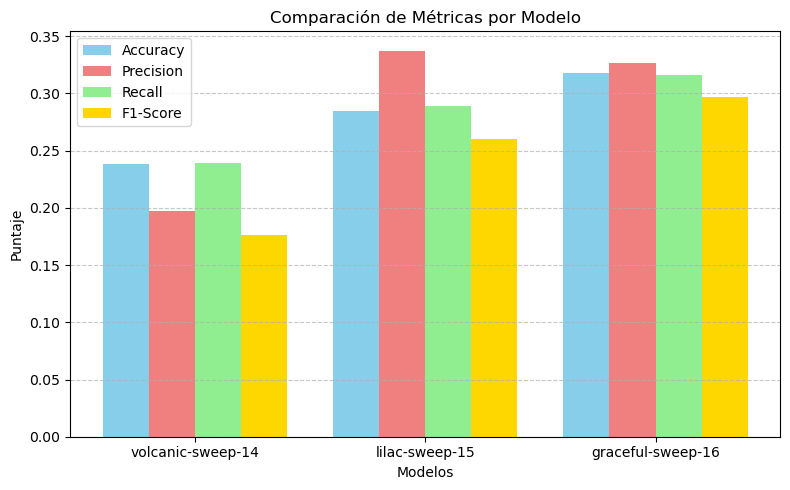


=== RESUMEN DE MÉTRICAS ===
Total de runs completados: 3

--- Accuracy ---
Mejor: graceful-sweep-16 0.3177

--- Precision ---
Mejor: lilac-sweep-15 0.3374

--- Recall ---
Mejor: graceful-sweep-16 0.3161

--- F1-Score ---
Mejor: graceful-sweep-16 0.2970


In [ ]:
# Crear un bar chart que compare los resultados de los sweeps
import matplotlib.pyplot as plt
import numpy as np

# Obtener todos los runs del sweep
api = wandb.Api()
ENTITY = api.default_entity
sweep = api.sweep(f"{ENTITY}/{WANDB_PROJECT}/{sweep_id}")

# Extraer datos de todos los runs
runs = []
run_names = []

for run in sweep.runs:
    if run.state == "finished":  # Solo runs completados
        runs.append(run)
        run_names.append(run.name)
print("run_names", run_names)
run_names = ['volcanic-sweep-14', 'lilac-sweep-15', 'graceful-sweep-16']
print("run_names", run_names)

# Crear subplots para mostrar todas las métricas
# fig, axes = plt.subplots(2, 2, figsize=(20, 12))
# fig.suptitle('Métricas de Rendimiento por Sweep Run', fontsize=16, fontweight='bold')

# Configurar colores para cada métrica
colors = ['skyblue', 'lightcoral', 'lightgreen', 'gold']
metrics = [accuracies, precisions, recalls, f1_scores]
metric_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
y_labels = ['Accuracy', 'Precision', 'Recall', 'F1-Score']

# Crear gráfico combinado (manteniendo tu lógica)
x = np.arange(len(run_names))  # posiciones de las barras por modelo
width = 0.2  # ancho de cada barra

# Crear figura
fig, ax = plt.subplots(figsize=(8, 5))

# Dibujar cada métrica desplazada
for i, metric in enumerate(metrics):
    if len(metric) != len(run_names):
        print(f"⚠️ Longitud de {metric_names[i]} ({len(metric)}) no coincide con run_names ({len(run_names)}). Se omite.")
        continue
    ax.bar(x + i*width, metric, width, label=metric_names[i], color=colors[i])

# Personalización
ax.set_xlabel("Modelos")
ax.set_ylabel("Puntaje")
ax.set_title("Comparación de Métricas por Modelo")
ax.set_xticks(x + width * (len(metrics)-1)/2)
ax.set_xticklabels(run_names)
ax.legend()
ax.grid(axis='y', linestyle='--', alpha=0.7)

# Mostrar
plt.tight_layout()
plt.show()

# Mostrar información adicional
print(f"\n=== RESUMEN DE MÉTRICAS ===")
print(f"Total de runs completados: {len(run_names)}")
print(f"\n--- Accuracy ---")
maxArg = np.argmax(accuracies)
print(f"Mejor: {run_names[maxArg]} {accuracies[maxArg]:.4f}")

print(f"\n--- Precision ---")
maxArg = np.argmax(precisions)
print(f"Mejor: {run_names[maxArg]} {precisions[maxArg]:.4f}")

print(f"\n--- Recall ---")
maxArg = np.argmax(recalls)
print(f"Mejor: {run_names[maxArg]} {recalls[maxArg]:.4f}")


print(f"\n--- F1-Score ---")
maxArg = np.argmax(f1_scores)
print(f"Mejor: {run_names[maxArg]} {f1_scores[maxArg]:.4f}")

# Mostrar tabla de resultados
# print(f"\n=== TABLA DE RESULTADOS ===")
# print(f"{'Run Name':<20} {'Accuracy':<10} {'Precision':<10} {'Recall':<10} {'F1-Score':<10}")
# print("-" * 70)
# for i, name in enumerate(run_names):
#     print(f"{name:<20} {accuracies[i]:<10.4f} {precisions[i]:<10.4f} {recalls[i]:<10.4f} {f1_scores[i]:<10.4f}")




In [78]:
api = wandb.Api()

# ULTIMA CORRIDA
# Create sweep with ID: 2ff0um8y
# Sweep URL: https://wandb.ai/mc-ort/Tarea1_LeNet_2/sweeps/2ff0um8y

ENTITY = api.default_entity
sweep = api.sweep(f"{ENTITY}/{WANDB_PROJECT}/{sweep_id}")

# nos traemos el sweep (objeto) para analizar los resultados
# sweep = api.sweep(f"{WANDB_TEAM_NAME}/{WANDB_PROJECT}/{sweep_id}")
 
# obtenemos el mejor run
best_run = sweep.best_run()

# imprimimos el mejor run
print("best run:", best_run)
# print(f"Best run {best_run.name} with {best_run.summary['val_loss']} {best_run.id}")
# print("Best run metrics:", best_run.summary)

print("Best run name:", best_run.name)
print("Best run name:", best_run.id)
print("Best run config:", best_run.config)

# descargamos el modelo del mejor run
best_run.file("model.pth").download(replace=True)

wandb: Sorting runs by -summary_metrics.val_macro_f1


best run: <Run campiglianatalia-ort/Tarea1_LeNet_2/0lxqqaz7 (finished)>
Best run name: different-sweep-12
Best run name: 0lxqqaz7
Best run config: {"_wandb": {"value": {"e": {"tlrfbgaccadfi4fwihmqxbfrimlkkhga": {"os": "macOS-15.1-arm64-arm-64bit-Mach-O", "git": {"commit": "975838582c5f95e404b55aeb81f1f79223584089", "remote": "https://github.com/nataliacampiglia/tdl_tarea_1.git"}, "disk": {"/": {"used": "220941348864", "total": "494384795648"}}, "host": "Natalias-MacBook-Pro-2.local", "root": "/Users/nataliacampigliastemphelet/master/tdl_tarea_1", "apple": {"name": "Apple M4 Pro", "gpuCores": 16, "memoryGb": 24, "ecpuCores": 4, "pcpuCores": 8, "ramTotalBytes": "25769803776", "swapTotalBytes": "10737418240"}, "email": "campiglianatalia@gmail.com", "memory": {"total": "25769803776"}, "python": "CPython 3.13.7", "program": "./Tarea_1_letra.ipynb", "codePath": "Tarea_1_letra.ipynb", "writerId": "tlrfbgaccadfi4fwihmqxbfrimlkkhga", "cpu_count": 12, "startedAt": "2025-10-12T20:22:03.763613Z", 

<_io.TextIOWrapper name='./model.pth' mode='r' encoding='UTF-8'>

In [30]:
attrs = [a for a in dir(best_run) if not a.startswith("_")]
print(attrs)

['client', 'config', 'create', 'delete', 'dir', 'display', 'entity', 'file', 'files', 'history', 'id', 'json_config', 'lastHistoryStep', 'load', 'load_full_data', 'log_artifact', 'logged_artifacts', 'metadata', 'name', 'path', 'project', 'rawconfig', 'save', 'scan_history', 'server_provides_internal_id_field', 'snake_to_camel', 'state', 'storage_id', 'summary', 'summary_metrics', 'sweep', 'sweep_name', 'system_metrics', 'to_html', 'update', 'upload_file', 'url', 'use_artifact', 'used_artifacts', 'user', 'username', 'wait_until_finished']


In [31]:
print("SUMMARY:",best_run.summary_metrics)


SUMMARY: {"_runtime":103,"_step":1,"_timestamp":1760299466.126972,"_wandb":{"runtime":103},"epoch":2,"train_loss":2.186723080616963,"val_loss":2.189457426552011}


In [32]:
import json

s = best_run.summary_metrics  # o best_run.summary
if isinstance(s, dict):
    val_loss = s.get("val_loss")
elif isinstance(s, str):
    val_loss = json.loads(s).get("val_loss")
else:
    # fallback por si W&B lo envuelve en un objeto raro
    val_loss = getattr(s, "get", lambda *_: None)("val_loss")

print("val_loss:", val_loss)

val_loss: 2.189457426552011


In [ ]:
# restauramos el modelo
letnet_model.load_state_dict(torch.load("model.pth"))

<All keys matched successfully>

In [34]:

criterion = nn.CrossEntropyLoss().to(DEVICE)

# este get_dataloaders no deberia estar aca, lo puse de mientras porque me estaba dando un error que no reconocia variables, puede ser porque estuvo wandb corriendo tantas horas que perdio contexto???
train_loader, val_loader, test_loader = get_dataloaders(train_tfms_lenet, val_tfms_lenet, BATCH_SIZE, NUM_WORKERS)
    
# Evaluamos el modelo en el conjunto de test
test_loss = evaluate(letnet_model, criterion, test_loader, DEVICE)  # tengo que traer el criterion que se halla usado en ese modelo

print(f"Test Loss: {test_loss:.5f}")

Test Loss: 2.17255


In [35]:
model_classification_report(letnet_model, test_loader, DEVICE, NUM_CLASES)

Accuracy: 0.1827

Reporte de clasificación:
               precision    recall  f1-score      support
0              0.091168  0.082687  0.086721   387.000000
1              0.000000  0.000000  0.000000   395.000000
2              0.132632  0.176471  0.151442   357.000000
3              0.750000  0.007772  0.015385   386.000000
4              0.000000  0.000000  0.000000   409.000000
5              0.154196  0.774112  0.257167   394.000000
6              0.295918  0.074550  0.119097   389.000000
7              0.200000  0.002387  0.004717   419.000000
8              0.000000  0.000000  0.000000   399.000000
9              0.280079  0.728205  0.404558   390.000000
accuracy       0.182675  0.182675  0.182675     0.182675
macro avg      0.190399  0.184618  0.103909  3925.000000
weighted avg   0.188797  0.182675  0.102158  3925.000000
Macro Avg:
 {'precision': 0.19039930906609953, 'recall': 0.18461835141735797, 'f1-score': 0.10390866329397616, 'support': 3925.0}
Precision:
 0.1903993090660

/Users/nataliacampigliastemphelet/miniconda3/envs/taller-dl/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/nataliacampigliastemphelet/miniconda3/envs/taller-dl/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/nataliacampigliastemphelet/miniconda3/envs/taller-dl/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` par

(0.1826751592356688,
 0.19039930906609953,
 0.18461835141735797,
 0.10390866329397616,
 3925.0)

In [36]:
import wandb, json

api = wandb.Api()

ENTITY = api.default_entity  # usá el entity correcto según tu URL
RUN_ID  = "4n4q5wiq"               # <- el run que querés

# 1) Traer el run por path
run_path = f"{ENTITY}/{WANDB_PROJECT}/{RUN_ID}"
run = api.run(run_path)

print("RUN:", run.id, "| name:", run.name)
print("URL:", run.url)
print("STATE:", run.state)
print("CONFIG:", dict(run.config))

# 2) Leer summary de forma segura (algunas versiones lo devuelven como string)
def summary_dict(r):
    s = getattr(r, "summary_metrics", None)
    if isinstance(s, str):
        try:
            return json.loads(s)
        except Exception:
            return {}
    if isinstance(s, dict):
        return s
    # fallback para r.summary con wrapper antiguo
    s2 = getattr(getattr(r, "summary", {}), "_json_dict", {})
    if isinstance(s2, dict):
        return s2
    return {}

summary = summary_dict(run)
print("SUMMARY KEYS:", [k for k in summary.keys() if not k.startswith("_")])
print("val_loss:", summary.get("val_loss"))

# 3) Descargar el modelo de ese run
#    Si el archivo exacto no existe, listá los .pth disponibles.
try:
    run.file("model.pth").download(replace=True)
    print("Descargado: model.pth")
except Exception as e:
    print("No encontré model.pth directamente:", e)
    print("Buscando .pth disponibles en el run...")
    pth_files = [f for f in run.files() if f.name.endswith(".pth")]
    for f in pth_files:
        print("->", f.name, f.size)
    if pth_files:
        pth_files[0].download(replace=True)
        print("Descargado:", pth_files[0].name)
    else:
        print("No hay archivos .pth en este run.")


RUN: 4n4q5wiq | name: clean-sweep-13
URL: https://wandb.ai/campiglianatalia-ort/Tarea1_LeNet_2/runs/4n4q5wiq
STATE: finished
CONFIG: {'patience': 6, 'dropout_p': 0.2, 'optimizer': 'adam', 'batch_size': 16, 'early_stop': True, 'weight_decay': 0.0001, 'learning_rate': 0.0012923728796005376, 'label_smoothing': 0.05, 'gradient_accumulation_steps': 8}
SUMMARY KEYS: ['epoch', 'train_loss', 'val_loss']
val_loss: 1.8528899470965068
Descargado: model.pth


In [ ]:
letnet_model.load_state_dict(torch.load("model.pth"))

<All keys matched successfully>

In [38]:
def getValue(data, value_name):
    if isinstance(data, dict):
        value = data.get(value_name)
    elif isinstance(data, str):
        value = json.loads(data).get(value_name)
    else:
        # fallback por si W&B lo envuelve en un objeto raro
        value = getattr(data, "get", lambda *_: None)(value_name)

    print("val_loss:", val_loss)
    return value

In [39]:

criterion = nn.CrossEntropyLoss().to(DEVICE)

# este get_dataloaders no deberia estar aca, lo puse de mientras porque me estaba dando un error que no reconocia variables, puede ser porque estuvo wandb corriendo tantas horas que perdio contexto???
train_loader, val_loader, test_loader = get_dataloaders(train_tfms_lenet, val_tfms_lenet, BATCH_SIZE, NUM_WORKERS)
   
    
# Evaluamos el modelo en el conjunto de test
test_loss = evaluate(letnet_model, criterion, test_loader, DEVICE)  # tengo que traer el criterion que se halla usado en ese modelo

print(f"Test Loss: {test_loss:.5f}")

Test Loss: 1.79953


In [40]:
model_classification_report(letnet_model, test_loader, DEVICE, NUM_CLASES)

Accuracy: 0.3885

Reporte de clasificación:
               precision    recall  f1-score      support
0              0.469274  0.434109  0.451007   387.000000
1              0.386525  0.275949  0.322009   395.000000
2              0.281134  0.638655  0.390411   357.000000
3              0.231214  0.103627  0.143113   386.000000
4              0.513433  0.420538  0.462366   409.000000
5              0.288646  0.535533  0.375111   394.000000
6              0.404199  0.395887  0.400000   389.000000
7              0.291892  0.128878  0.178808   419.000000
8              0.538776  0.330827  0.409938   399.000000
9              0.606132  0.658974  0.631450   390.000000
accuracy       0.388535  0.388535  0.388535     0.388535
macro avg      0.401122  0.392298  0.376421  3925.000000
weighted avg   0.402171  0.388535  0.375440  3925.000000
Macro Avg:
 {'precision': 0.4011224319805695, 'recall': 0.39229777893714146, 'f1-score': 0.3764211403372206, 'support': 3925.0}
Precision:
 0.401122431980569

(0.3885350318471338,
 0.4011224319805695,
 0.39229777893714146,
 0.3764211403372206,
 3925.0)

## Conclusión de los datos

In [41]:
#

# Arquitectura DenseNet


In [42]:
IMG_SIZE = 128

In [43]:
class DenseLayer(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DenseLayer, self).__init__()
        self.bn = nn.BatchNorm2d(in_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)

    def forward(self, x):
        y = self.conv(self.relu(self.bn(x)))
        return torch.cat([x,y] , dim=1)

`growth_rate` indica cuántos canales se agregarán en cada capa convolucional dentro de un bloque denso

In [44]:
from torchinfo import summary

in_channels  = 6  # número de canales de entrada
out_channels = 4 # número de canales de salida
dense_layer = DenseLayer(in_channels=in_channels, out_channels=out_channels)
summary(dense_layer, input_size=(BATCH_SIZE, in_channels, IMG_SIZE, IMG_SIZE))

Layer (type:depth-idx)                   Output Shape              Param #
DenseLayer                               [32, 10, 128, 128]        --
├─BatchNorm2d: 1-1                       [32, 6, 128, 128]         12
├─ReLU: 1-2                              [32, 6, 128, 128]         --
├─Conv2d: 1-3                            [32, 4, 128, 128]         220
Total params: 232
Trainable params: 232
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 115.34
Input size (MB): 12.58
Forward/backward pass size (MB): 41.94
Params size (MB): 0.00
Estimated Total Size (MB): 54.53

In [45]:
class DenseBlock(nn.Module):
    def __init__(self, num_layers, in_channels, growth_rate):
        super(DenseBlock, self).__init__()
        self.block = []
        for i in range(num_layers):
            self.block += [DenseLayer(in_channels + i * growth_rate, growth_rate)]
        self.denseBlock = nn.Sequential(*self.block)
        

    def forward(self, x):
       return self.denseBlock(x)

In [46]:
in_channels = 6  # número de canales de entrada
num_layer   = 5  # número de capas en el bloque denso
growth_rate = 4  # tasa de crecimiento

dense_block = DenseBlock(num_layer, in_channels, growth_rate)

summary(dense_block, input_size=(BATCH_SIZE, in_channels, IMG_SIZE, IMG_SIZE))

Layer (type:depth-idx)                   Output Shape              Param #
DenseBlock                               [32, 26, 128, 128]        --
├─Sequential: 1-1                        [32, 26, 128, 128]        --
│    └─DenseLayer: 2-1                   [32, 10, 128, 128]        --
│    │    └─BatchNorm2d: 3-1             [32, 6, 128, 128]         12
│    │    └─ReLU: 3-2                    [32, 6, 128, 128]         --
│    │    └─Conv2d: 3-3                  [32, 4, 128, 128]         220
│    └─DenseLayer: 2-2                   [32, 14, 128, 128]        --
│    │    └─BatchNorm2d: 3-4             [32, 10, 128, 128]        20
│    │    └─ReLU: 3-5                    [32, 10, 128, 128]        --
│    │    └─Conv2d: 3-6                  [32, 4, 128, 128]         364
│    └─DenseLayer: 2-3                   [32, 18, 128, 128]        --
│    │    └─BatchNorm2d: 3-7             [32, 14, 128, 128]        28
│    │    └─ReLU: 3-8                    [32, 14, 128, 128]        --
│    │    └─C

In [47]:
class TransitionLayer(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(TransitionLayer, self).__init__()
        self.bn = nn.BatchNorm2d(in_channels)
        self.relu = nn.ReLU(inplace=True) #optional
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)
        self.pool = nn.AvgPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        # x = self.conv(self.bn(x))
        x = self.conv(self.relu(self.bn(x))) #relu es opcional
        return self.pool(x)

In [48]:
in_channels = 100  # número de canales de entrada
out_channels = 25  # número de canales de salida (en general, se reduce a la mitad)
img_w = 32  # ancho de la imagen
img_h = 32  # alto de la imagen

transition_layer = TransitionLayer(in_channels, out_channels)

summary(transition_layer, input_size=(BATCH_SIZE, in_channels, IMG_SIZE, IMG_SIZE))

Layer (type:depth-idx)                   Output Shape              Param #
TransitionLayer                          [32, 25, 64, 64]          --
├─BatchNorm2d: 1-1                       [32, 100, 128, 128]       200
├─ReLU: 1-2                              [32, 100, 128, 128]       --
├─Conv2d: 1-3                            [32, 25, 128, 128]        2,525
├─AvgPool2d: 1-4                         [32, 25, 64, 64]          --
Total params: 2,725
Trainable params: 2,725
Non-trainable params: 0
Total mult-adds (Units.GIGABYTES): 1.32
Input size (MB): 209.72
Forward/backward pass size (MB): 524.29
Params size (MB): 0.01
Estimated Total Size (MB): 734.01

In [ ]:
class DenseNet(nn.Module):
    def __init__(self, num_layers = [6, 12, 24, 16], growth_rate=32, num_classes=10, dropout_p=0.0):
        super(DenseNet, self).__init__()
        self.growth_rate = growth_rate
        self.num_layers = num_layers
        self.num_blocks = len(num_layers)

        # Capa inicial: se encarga de extraer características iniciales
        current_channels = 3
        self.convI = nn.Conv2d(current_channels, 2*growth_rate, kernel_size=3, padding=1)
        current_channels = 2*growth_rate
        self.poolI = nn.MaxPool2d(2, 2)
        self.bnI = nn.BatchNorm2d(current_channels)
        self.relu = nn.ReLU(True)

        dense_blocks = []
        # Bloques densos y capas de transición en nn.Sequential
        for i in range(self.num_blocks):
            current_layers = num_layers[i]
            dense_blocks += [DenseBlock(current_layers, current_channels, growth_rate)]
            current_channels += current_layers * growth_rate
            if i < self.num_blocks - 1:
                dense_blocks += [TransitionLayer(current_channels, current_channels // 2)]
                current_channels = current_channels // 2
        self.dense_blocks = nn.Sequential(*dense_blocks)

        # Capa de clasificación
        self.avgPool = nn.AdaptiveAvgPool2d((1,1))
        self.flatten = nn.Flatten(start_dim=1)
        self.classifier = nn.Linear(current_channels, num_classes)
        

    def forward(self, x):
        x = self.relu(self.bnI(self.convI(x)))
        x = self.dense_blocks(x)
        x = self.avgPool(x)
        x = self.flatten(x)
        x = self.classifier(x)
        return x


# Ejemplo de uso
model = DenseNet(num_layers=[6, 12, 24, 16], growth_rate=32, num_classes=10)

summary(model, input_size=(BATCH_SIZE, 3, IMG_SIZE, IMG_SIZE), depth=3)

Layer (type:depth-idx)                        Output Shape              Param #
DenseNet                                      [32, 10]                  --
├─Conv2d: 1-1                                 [32, 64, 128, 128]        1,792
├─BatchNorm2d: 1-2                            [32, 64, 128, 128]        128
├─ReLU: 1-3                                   [32, 64, 128, 128]        --
├─Sequential: 1-4                             [32, 1024, 16, 16]        --
│    └─DenseBlock: 2-1                        [32, 256, 128, 128]       --
│    │    └─Sequential: 3-1                   [32, 256, 128, 128]       250,752
│    └─TransitionLayer: 2-2                   [32, 128, 64, 64]         --
│    │    └─BatchNorm2d: 3-2                  [32, 256, 128, 128]       512
│    │    └─ReLU: 3-3                         [32, 256, 128, 128]       --
│    │    └─Conv2d: 3-4                       [32, 128, 128, 128]       32,896
│    │    └─AvgPool2d: 3-5                    [32, 128, 64, 64]         --
│    └

In [50]:
train_loader, val_loader, test_loader = get_dataloaders(train_tfms_lenet, val_tfms_lenet, BATCH_SIZE, NUM_WORKERS)


In [51]:
import torch, gc

def mps_cleanup():
    gc.collect()
    if torch.backends.mps.is_available():
        print('clean')
        torch.mps.empty_cache()
        torch.mps.synchronize()

# Llama esto entre épocas o antes de relanzar un experimento
mps_cleanup()

clean


In [52]:
import os
os.environ["PYTORCH_MPS_HIGH_WATERMARK_RATIO"] = "0.95"
import torch

In [ ]:
model = DenseNet(
    num_layers=[6, 12, 24, 16], growth_rate=12, num_classes=10
).to(DEVICE)

optimizer = optim.Adam(model.parameters(), lr=LR)

CRITERION = nn.CrossEntropyLoss().to(DEVICE)

train_errors_dn, val_errors_dn = train(
    model=model,
    optimizer=optimizer,
    criterion=CRITERION,
    train_loader=train_loader,
    val_loader=val_loader,
    device=DEVICE,
    do_early_stopping=True,
    patience=8,
    epochs=EPOCHS,
)

Epoch: 001 | Train Loss: 2.02012 | Val Loss: 2.10934


KeyboardInterrupt: 

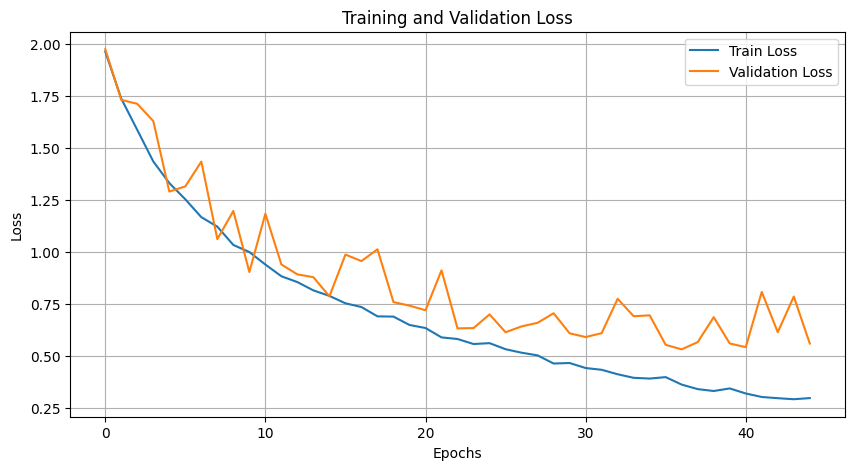

In [ ]:
plot_training(train_errors_dn, val_errors_dn)

In [ ]:
model_classification_report(model, test_loader, DEVICE, NUM_CLASES)

Accuracy: 0.8375

Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.90      0.89      0.89       387
           1       0.97      0.82      0.89       395
           2       0.77      0.90      0.83       357
           3       0.63      0.75      0.68       386
           4       0.91      0.85      0.88       409
           5       0.82      0.86      0.84       394
           6       0.84      0.90      0.87       389
           7       0.83      0.75      0.79       419
           8       0.85      0.86      0.86       399
           9       0.94      0.80      0.87       390

    accuracy                           0.84      3925
   macro avg       0.85      0.84      0.84      3925
weighted avg       0.85      0.84      0.84      3925



In [ ]:
IMG_SIZE = 224
BATCH_SIZE = 32

In [ ]:
train_tfms_denseNet = T.Compose([
    T.RandomHorizontalFlip(p=0.5),
    T.RandomRotation(degrees=10),
    # Transformaciones comunes:
    T.ToImage(),
    T.ToDtype(torch.float32, scale=True),
    T.Resize((IMG_SIZE, IMG_SIZE)),
    T.Normalize(mean=T_MEAN, std=T_STD),
])

val_tfms_denseNet = T.Compose([
    T.ToImage(),
    T.ToDtype(torch.float32, scale=True),
    T.Resize((IMG_SIZE, IMG_SIZE)),
    T.Normalize(mean=T_MEAN, std=T_STD),
])

In [ ]:
train_loader, val_loader, test_loader = get_dataloaders(train_tfms_denseNet, val_tfms_denseNet, BATCH_SIZE, NUM_WORKERS)

In [ ]:
import torch, gc


gc.collect()                 # Limpia objetos Python no referenciados
torch.cuda.empty_cache()     # Devuelve memoria al driver (visible en nvidia-smi)
torch.cuda.ipc_collect()


In [ ]:
model = DenseNet(
    num_layers=[6, 12, 24, 16], growth_rate=12, num_classes=NUM_CLASES
).to(DEVICE)

optimizer = optim.Adam(model.parameters(), lr=LR)

CRITERION = nn.CrossEntropyLoss().to(DEVICE)

train_errors_dn, val_errors_dn = train(
    model=model,
    optimizer=optimizer,
    criterion=CRITERION,
    train_loader=train_loader,
    val_loader=val_loader,
    device=DEVICE,
    do_early_stopping=True,
    patience=8,
    epochs=EPOCHS,
)

OutOfMemoryError: CUDA out of memory. Tried to allocate 148.00 MiB. GPU 0 has a total capacity of 10.57 GiB of which 35.12 MiB is free. Process 2809942 has 10.53 GiB memory in use. Of the allocated memory 9.85 GiB is allocated by PyTorch, and 496.40 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
print(torch.cuda.memory_summary(abbreviated=True))
# durante entrenamiento
print("alloc:", torch.cuda.memory_allocated()/1024**2, "MB",
      "reserved:", torch.cuda.memory_reserved()/1024**2, "MB")

## Carga de datos con transformers

## Data augmentation

## Preprocessing

## Arquitectura del modelo

## Regularización

## Entrenamiento

## Weight & Biases

## Conclusión de los datos

# Comparación ambos modelos

Usando best-model wandb de cada uno

* Tabla comparativa de métricas (accuracy, F1, etc.).
* Gráficas comparativas.
* Matrices de confusión lado a lado.
* Discusión de resultados.